# Regression using Data Driven approaches

## Context
In this notebook, we will consider a first principle Monod Kenetic model for cell growth.

$$
\mu = \mu_{max} * \dfrac{S}{K_S + S} \\
$$
The balances are described as follows for the biomass:
$$
\dfrac{dX}{dt} = \mu * X \\
$$
And the substrate:
$$
\dfrac{dS}{dt} = -\dfrac{1}{Y_{xs}} * \mu * X
$$

We will use this model to "generate" a dataset. We will assume the trye kenetics are unknown.

## Data generation

To generate the data we first need to implement the model.


In [1]:
# implement the model
def monod_model(y,t, mu_max, Yxs, S0):
    X, S = y
    # define mu maxc

    # define the derivatives
    dXdt = 0
    dSdt = 0
    return [dXdt, dSdt] 

For generating the data, we will use the following parameters

| Parameter     | Value | Unit 	| Info                       |
|---	        |---	|---	|---                         |
| $\mu_{max}$  	|  0.5 	|   	| maximum growth rate        |
| $K_S 	        |  0.2 	|   	| half-saturation constant   |
| $Y_{XS}$      |  0.4 	|   	| Yield coefficient          |

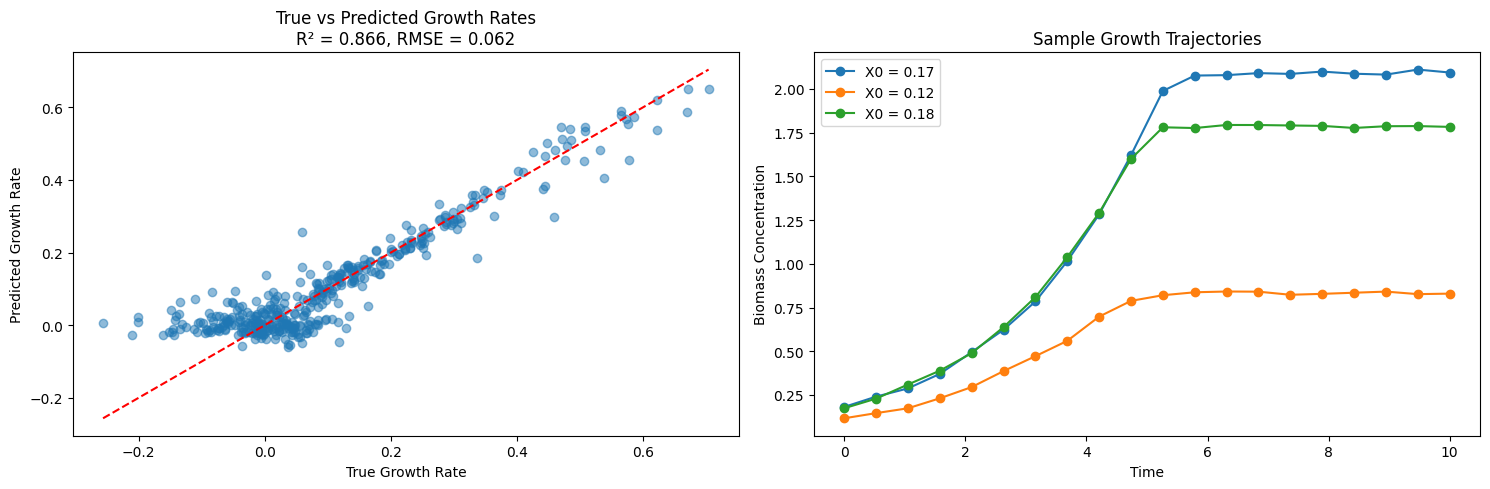


Optimal Initial Conditions for target biomass 1.0:
Initial Biomass (X0): 0.122
Initial Substrate (S0): 1.889


In [2]:
# Hybrid Machine Learning in Biochemical Engineering: 
# Bioreactor Case Study

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from scipy.integrate import odeint
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# 1. First Principles Model: Monod Kinetics for Cell Growth
def monod_model(y, t, μmax, Ks, Yxs, S0):
    X, S = y  # X: biomass, S: substrate
    
    # Monod equation
    μ = μmax * S / (Ks + S)
    
    # Differential equations
    dXdt = μ * X
    dSdt = -(1/Yxs) * μ * X
    
    return [dXdt, dSdt]

# Generate synthetic data using first principles model
def generate_data(n_samples=100):
    # True parameter values
    μmax_true = 0.5  # maximum growth rate
    Ks_true = 0.2    # half-saturation constant
    Yxs_true = 0.4   # yield coefficient
    
    # Initial conditions range
    X0_range = (0.1, 0.3)
    S0_range = (1.0, 5.0)
    
    # Time points
    t = np.linspace(0, 10, 20)
    
    data = []
    
    for _ in range(n_samples):
        # Random initial conditions
        X0 = np.random.uniform(*X0_range)
        S0 = np.random.uniform(*S0_range)
        
        # Solve ODE
        solution = odeint(monod_model, [X0, S0], t, 
                         args=(μmax_true, Ks_true, Yxs_true, S0))
        
        # Add noise to simulate real measurements
        X_noisy = solution[:, 0] + np.random.normal(0, 0.01, len(t))
        S_noisy = solution[:, 1] + np.random.normal(0, 0.02, len(t))
        
        # Store results
        for i in range(len(t)):
            data.append({
                't': t[i],
                'X0': X0,
                'S0': S0,
                'X': max(0, X_noisy[i]),  # ensure non-negative
                'S': max(0, S_noisy[i]),
                'dXdt': monod_model([X_noisy[i], S_noisy[i]], t[i], 
                                  μmax_true, Ks_true, Yxs_true, S0)[0]
            })
    
    return pd.DataFrame(data)

# Generate training data
df = generate_data(n_samples=100)

# 2. Hybrid ML Model Development

# Prepare features and target
feature_columns = ['t', 'X0', 'S0', 'X', 'S']
X = df[feature_columns]
y = df['dXdt']

# Scale features while preserving column names
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=feature_columns
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Train neural network
nn_model = MLPRegressor(hidden_layer_sizes=(30, 20, 10),
                       activation='relu',
                       solver='adam',
                       max_iter=1000,
                       random_state=42)

nn_model.fit(X_train, y_train)

# 3. Model Evaluation and Visualization

# Make predictions
y_pred = nn_model.predict(X_test)

# Calculate metrics
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Create visualization
plt.figure(figsize=(15, 5))

# Plot 1: True vs Predicted Growth Rates
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('True Growth Rate')
plt.ylabel('Predicted Growth Rate')
plt.title('True vs Predicted Growth Rates\n' + 
          f'R² = {r2:.3f}, RMSE = {rmse:.3f}')

# Plot 2: Growth Trajectories
plt.subplot(1, 2, 2)
sample_trajectories = df[df['X0'].isin(df['X0'].unique()[:3])]
for X0 in sample_trajectories['X0'].unique():
    trajectory = sample_trajectories[sample_trajectories['X0'] == X0]
    plt.plot(trajectory['t'], trajectory['X'], 'o-', label=f'X0 = {X0:.2f}')
plt.xlabel('Time')
plt.ylabel('Biomass Concentration')
plt.title('Sample Growth Trajectories')
plt.legend()

plt.tight_layout()
plt.show()

# 4. Process Optimization using Hybrid Model

def optimize_initial_conditions(target_biomass, time_point=8.0):
    # Grid search over initial conditions
    X0_range = np.linspace(0.1, 0.3, 10)
    S0_range = np.linspace(1.0, 5.0, 10)
    
    best_conditions = None
    min_error = float('inf')
    
    for X0 in X0_range:
        for S0 in S0_range:
            # Create feature vector with proper column names
            features = pd.DataFrame([[time_point, X0, S0, X0, S0]], 
                                 columns=feature_columns)
            features_scaled = pd.DataFrame(
                scaler.transform(features),
                columns=feature_columns
            )
            
            # Predict growth rate
            pred_rate = nn_model.predict(features_scaled)[0]
            
            # Approximate final biomass using simple integration
            final_biomass = X0 * np.exp(pred_rate * time_point)
            
            # Calculate error
            error = abs(final_biomass - target_biomass)
            
            if error < min_error:
                min_error = error
                best_conditions = (X0, S0)
    
    return best_conditions

# Example optimization
target_biomass = 1.0
optimal_X0, optimal_S0 = optimize_initial_conditions(target_biomass)

print(f"\nOptimal Initial Conditions for target biomass {target_biomass}:")
print(f"Initial Biomass (X0): {optimal_X0:.3f}")
print(f"Initial Substrate (S0): {optimal_S0:.3f}")